# Home Loan Approval/Denial

#### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.svm import SVC

from sklearn import set_config

set_config(display="diagram")

#### Auxiliary variables

In [3]:
filename_input = "data-hdma-eastbay-2019-2022-processed"
filename_output = "data-hdma-eastbay-2019-2022-sklearn"

#### Loading the processed data

In [4]:
df = pd.read_csv(f"../../{filename_input}.csv", index_col=0)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 219267 entries, 34 to 544843
Data columns (total 37 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   debt_to_income_ratio_df            219267 non-null  float64
 1   property_value                     219267 non-null  float64
 2   loan_term                          219267 non-null  float64
 3   loan_to_value_ratio                219267 non-null  float64
 4   loan_amount                        219267 non-null  float64
 5   income                             219267 non-null  float64
 6   tract_minority_population_percent  219267 non-null  float64
 7   tract_to_msa_income_percentage     219267 non-null  float64
 8   tract_population                   219267 non-null  float64
 9   tract_one_to_four_family_homes     219267 non-null  float64
 10  tract_median_age_of_housing_units  219267 non-null  float64
 11  tract_owner_occupied_units         219267 n

## 3. Preparing for modeling

### 3.1. Test features

In [6]:
df["sqrt_income"] = df["income"].apply(np.sqrt)
df["sqrt_property_value"] = df["property_value"].apply(np.sqrt)
df["sqrt_loan_amount"] = df["loan_amount"].apply(np.sqrt)

### 3.2. Lists of feature names

In [7]:
tract_features = [x for x in df.columns if x.startswith("tract_")]

numerical_loan_features = [
    "debt_to_income_ratio",
    # "debt_to_income_ratio_df",
    # "loan_term",
    "loan_to_value_ratio",
]
numerical_currency_features = ["property_value", "income", "loan_amount"]
numerical_sqrt_currency_features = [
    "sqrt_income",
    "sqrt_property_value",
    "sqrt_loan_amount",
]
categorical_applicant_features = [
    "applicant_sex",
    "applicant_race",
    "applicant_ethnicity",
    "applicant_age",
]
categorical_coapplicant_features = [
    "coapplicant_sex",
    "coapplicant_race",
    "coapplicant_ethnicity",
    "coapplicant_age",
]
categorical_loan_features = [
    # "conforming_loan_limit",
    "occupancy_type",
    # "hoepa_status",
    # "lien_status",
    "loan_purpose",
    "loan_type",
]
binary_features = [
    "applicant_age_above_62",
    "interest_only_payment",
    "business_or_commercial_purpose",
    "open-end_line_of_credit",
]

derived_features = [
    "derived_sex",
    "derived_race",
    "derived_ethnicity",
    "derived_loan_product_type",
]

target_related_features = ["denial_reason"]

target_feature = "application_outcome"

### 3.3. X,y

In [45]:
X = df[
    numerical_loan_features
    + numerical_currency_features
    + numerical_sqrt_currency_features
    # + categorical_applicant_features
    # + categorical_coapplicant_features
    + categorical_loan_features
    # + binary_features
    # + derived_features
]
y = df[target_feature].map({'Approved': 1, 'Denied': 0})

### 3.4. train/test split

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

### 3.5. Column transformers

In [47]:
categorical_columns = X.select_dtypes(include=object).columns
numerical_columns = X.select_dtypes(include=float).columns

print(categorical_columns)
print(numerical_columns)

Index(['occupancy_type', 'loan_purpose', 'loan_type'], dtype='object')
Index(['debt_to_income_ratio', 'loan_to_value_ratio', 'property_value',
       'income', 'loan_amount', 'sqrt_income', 'sqrt_property_value',
       'sqrt_loan_amount'],
      dtype='object')


In [48]:
def main_column_transformer():
    return ColumnTransformer(
        [
            ("ohe", OneHotEncoder(drop='if_binary', sparse_output=False), categorical_columns),
            ("scaler", StandardScaler(), numerical_columns),
        ],
        remainder="drop",
        verbose_feature_names_out=False,
    )

## 4. Modeling

In [49]:
def get_info(model):
    print(f"train score = {model.score(X_train, y_train)}")
    print(f"test score = {model.score(X_test, y_test)}")

### 4.1. Testing models

#### 4.1.0. Baseline

In [53]:
baseline = DummyClassifier().fit(X_train, y_train)
get_info(baseline)

train score = 0.6579427439636188
test score = 0.6579407427676685


#### 4.1.1. LogisticRegression

In [51]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", LogisticRegression(max_iter=1000)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.7716143491914572
test score = 0.7734756236603274
              precision    recall  f1-score   support

           0       0.74      0.52      0.61     22501
           1       0.79      0.90      0.84     43280

    accuracy                           0.77     65781
   macro avg       0.76      0.71      0.73     65781
weighted avg       0.77      0.77      0.76     65781



#### 4.1.2. Decision Tree

In [18]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", DecisionTreeClassifier(max_depth=3)),
    ]
)
pipeline.fit(X_train, y_train)
get_info(pipeline)
print(classification_report(y_test, pipeline.predict(X_test)))

train score = 0.7787420351041788
test score = 0.777473738617534
              precision    recall  f1-score   support

    Approved       0.76      0.97      0.85     43280
      Denied       0.88      0.41      0.56     22501

    accuracy                           0.78     65781
   macro avg       0.82      0.69      0.70     65781
weighted avg       0.80      0.78      0.75     65781



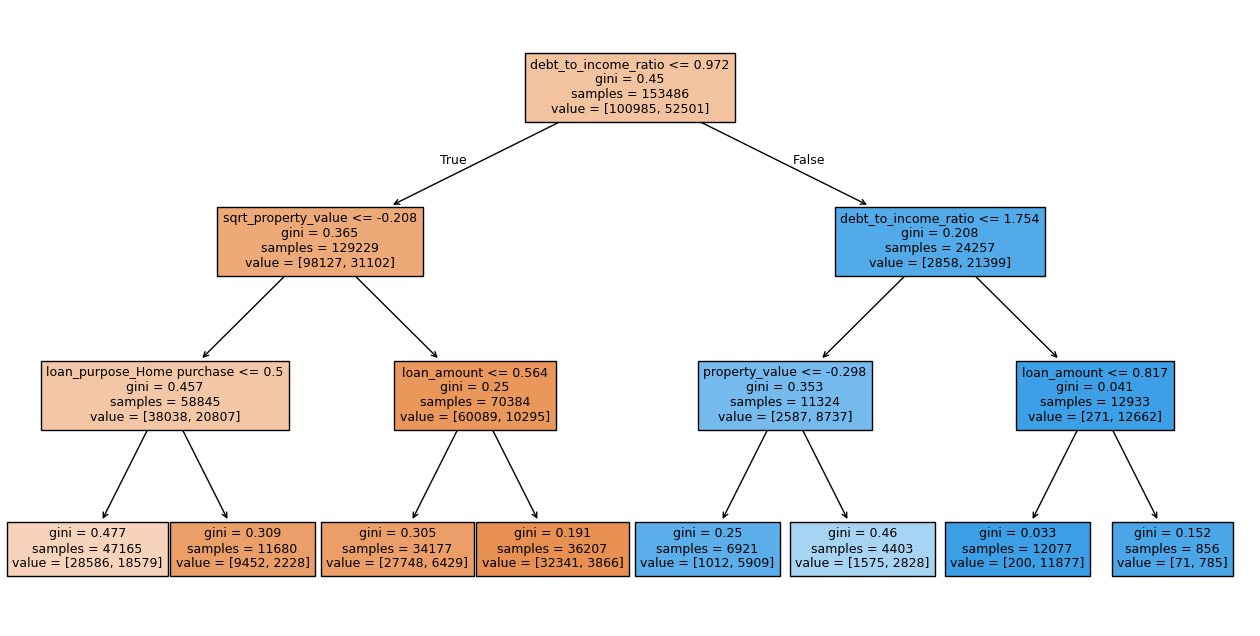

In [19]:
f, ax = plt.subplots(figsize=(16, 8))
plot_tree(
    pipeline.named_steps["model"],
    feature_names=pipeline[0].get_feature_names_out(),
    fontsize=9,
    filled=True,
    ax=ax,
)
plt.show()

### 4.2. Searching hyperparameters

#### 4.2.1. LogisticRegression

In [60]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", LogisticRegression(max_iter=10000)),
    ]
)
grid_lr = GridSearchCV(
    pipeline,
    param_grid={
        "model__C": 10.0 ** np.array([-4, -3, -2, -1, 0]),
    },
    cv=5,
    n_jobs = -1,
).fit(X_train, y_train)

In [63]:
get_info(grid_lr)
print(classification_report(y_test, grid_lr.predict(X_test)))

train score = 0.7716143491914572
test score = 0.7734756236603274
              precision    recall  f1-score   support

           0       0.74      0.52      0.61     22501
           1       0.79      0.90      0.84     43280

    accuracy                           0.77     65781
   macro avg       0.76      0.71      0.73     65781
weighted avg       0.77      0.77      0.76     65781



#### 4.2.3. Decision Tree

In [64]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", DecisionTreeClassifier()),
    ]
)
grid_dt = GridSearchCV(
    pipeline,
    param_grid={
        "model__criterion": ["gini", "entropy", "log_loss"],
        "model__max_depth": [4, 8, 12, 16],
    },
    cv=5,
    n_jobs=-1,
).fit(X_train, y_train)

In [65]:
grid_dt.best_params_

{'model__criterion': 'gini', 'model__max_depth': 8}

In [66]:
get_info(grid_dt)
print(classification_report(y_test, grid_dt.predict(X_test)))

train score = 0.7963788228242316
test score = 0.7947735668354085
              precision    recall  f1-score   support

           0       0.86      0.48      0.62     22501
           1       0.78      0.96      0.86     43280

    accuracy                           0.79     65781
   macro avg       0.82      0.72      0.74     65781
weighted avg       0.81      0.79      0.78     65781



#### 4.2.4. SVM

In [67]:
_, X_small, _, y_small = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
X_small = X_small.reset_index(drop=True)
y_small = y_small.reset_index(drop=True)
X_small_train, X_small_test, y_small_train, y_small_test = train_test_split(X_small, y_small, test_size=0.3, stratify=y_small, random_state=2)

In [68]:
X_small.shape

(21927, 11)

In [69]:
pipeline = Pipeline(
    [
        ("preprocess", main_column_transformer()),
        ("model", SVC()),
    ]
)
grid_svm = GridSearchCV(
    pipeline,
    param_grid={
        "model__C": 10.0 ** np.array([-1, 0, 1]),
    },
    verbose=4,
    cv=5,
    n_jobs=-1,
).fit(X_small_train, y_small_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 3/5] END ......................model__C=0.1;, score=0.774 total time=  10.2s
[CV 4/5] END ......................model__C=0.1;, score=0.788 total time=  10.3s
[CV 2/5] END ......................model__C=0.1;, score=0.788 total time=  10.5s
[CV 1/5] END ......................model__C=0.1;, score=0.784 total time=  10.8s
[CV 2/5] END ......................model__C=1.0;, score=0.798 total time=   9.8s
[CV 5/5] END ......................model__C=0.1;, score=0.780 total time=  10.4s
[CV 3/5] END ......................model__C=1.0;, score=0.788 total time=   9.9s
[CV 1/5] END ......................model__C=1.0;, score=0.787 total time=  10.6s
[CV 4/5] END ......................model__C=1.0;, score=0.799 total time=   9.6s
[CV 5/5] END ......................model__C=1.0;, score=0.794 total time=  10.5s
[CV 1/5] END .....................model__C=10.0;, score=0.789 total time=  12.2s
[CV 2/5] END .....................model__C=10.0;,

In [70]:
print(grid_svm.score(X_small_test, y_small_test))
print(grid_svm.score(X_test, y_test))
print(grid_svm.score(X_train, y_train))

0.7923696610427117
0.7974187075295298
0.7922872444392323


In [71]:
print(classification_report(y_test, grid_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.49      0.62     22501
           1       0.78      0.96      0.86     43280

    accuracy                           0.80     65781
   macro avg       0.82      0.72      0.74     65781
weighted avg       0.81      0.80      0.78     65781

